In [22]:
import os, sys

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

from src.data_loading import download_daily_prices, load_daily_close
from src.signals import (
    make_basic_signals,
    build_feature_matrix,
    build_sequence_dataset,
    DEFAULT_FEATURES,
)
from src.models_tree import train_tree_regressor, evaluate_regression
from src.models_lstm_class import train_lstm_classifier, predict_lstm_proba
from src.models_lstm import train_lstm_regressor, predict_lstm
from src.backtest import (
    equity_curve_from_returns,
    cagr,
    annualized_vol,
    sharpe_ratio,
    max_drawdown,
)


PROJECT_ROOT: c:\Users\gehra\Documents\GitHub\Quant_coding
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
ticker = "SPY"

# Load or download prices
try:
    prices = load_daily_close(ticker)
except FileNotFoundError:
    download_daily_prices(ticker, start="2010-01-01")
    prices = load_daily_close(ticker)

signals_df = make_basic_signals(prices)
signals_df.head(), signals_df.columns


c:\Users\gehra\Documents\GitHub\Quant_coding\src\data_loading.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_path, parse_dates=[0], index_col=0)


(                price     ret_1     ret_5    ret_10    vol_10    vol_20  \
 date                                                                      
 2010-03-16  87.596893  0.007966  0.017037  0.037523  0.004485  0.005395   
 2010-03-17  88.116074  0.005927  0.018527  0.042743  0.004417  0.005422   
 2010-03-18  88.070892 -0.000513  0.013772  0.039062  0.004657  0.005433   
 2010-03-19  87.625145 -0.005061  0.008554  0.019235  0.003771  0.005704   
 2010-03-22  88.093597  0.005346  0.013682  0.024504  0.003860  0.005718   
 
             ma10_rel  ma50_rel  target_ret_1  
 date                                          
 2010-03-16 -0.015807 -0.041416      0.005927  
 2010-03-17 -0.017506 -0.046420     -0.000513  
 2010-03-18 -0.013243 -0.045348     -0.005061  
 2010-03-19 -0.006336 -0.040022      0.005346  
 2010-03-22 -0.009228 -0.044635      0.007033  ,
 Index(['price', 'ret_1', 'ret_5', 'ret_10', 'vol_10', 'vol_20', 'ma10_rel',
        'ma50_rel', 'target_ret_1'],
       dtype='o

In [24]:
feature_names = DEFAULT_FEATURES

X, y, dates = build_feature_matrix(signals_df, feature_names)

split_idx = int(len(X) * 0.7)  # 70% train / 30% test

X_train, X_test = X[:split_idx], X[split_idx:]
y_train_float, y_test_float = y[:split_idx], y[split_idx:]
dates_train, dates_test = dates[:split_idx], dates[split_idx:]

print("Train size:", len(X_train), "Test size:", len(X_test))
print("Train period:", dates_train[0], "->", dates_train[-1])
print("Test period:", dates_test[0], "->", dates_test[-1])

# Standardise features for LSTM regressor
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape


Train size: 2769 Test size: 1188
Train period: 2010-03-16 -> 2021-03-15
Test period: 2021-03-16 -> 2025-12-04


((2769, 7), (1188, 7))

In [25]:
# --- Tree baseline ---
tree_model = train_tree_regressor(X_train, y_train_float)
reg_metrics_tree = evaluate_regression(tree_model, X_test, y_test_float)
preds_tree = reg_metrics_tree["preds"]
print("Tree test MSE:", reg_metrics_tree["mse"])

# Positions: long-only if predicted return > 0
positions_tree = (preds_tree > 0).astype(int)

# Returns on full test period
bh_returns = y_test_float                      # buy & hold
tree_returns = positions_tree * y_test_float   # tree strategy

# Series for full test period (we'll align later)
bh_series_full = signals_df["target_ret_1"].iloc[split_idx:].copy()
bh_series_full[:] = bh_returns

tree_series_full = bh_series_full.copy()
tree_series_full[:] = tree_returns

bh_series_full.head(), tree_series_full.head()


Tree test MSE: 0.00012079135215676687


(date
 2021-03-16    0.003410
 2021-03-17   -0.014550
 2021-03-18   -0.001850
 2021-03-19    0.007985
 2021-03-22   -0.007871
 Name: target_ret_1, dtype: float64,
 date
 2021-03-16    0.003410
 2021-03-17   -0.014550
 2021-03-18   -0.001850
 2021-03-19    0.007985
 2021-03-22   -0.007871
 Name: target_ret_1, dtype: float64)

In [26]:
# Direction labels for single-day features (no sequences)
y_train_class_simple = (y_train_float > 0).astype(int)
y_test_class_simple  = (y_test_float > 0).astype(int)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train_class_simple)

y_pred_simple = log_reg.predict(X_test)

base_rate_simple = y_test_class_simple.mean()
acc_simple = accuracy_score(y_test_class_simple, y_pred_simple)
bacc_simple = balanced_accuracy_score(y_test_class_simple, y_pred_simple)

print("Base rate (simple):", base_rate_simple)
print("LogReg accuracy:", acc_simple)
print("LogReg balanced acc:", bacc_simple)


Base rate (simple): 0.5471380471380471
LogReg accuracy: 0.5471380471380471
LogReg balanced acc: 0.5


In [27]:
seq_len = 30

# --- Sequences for CLASSIFIER (unscaled features) ---
X_train_seq, y_train_seq_float, dates_train_seq = build_sequence_dataset(
    X_train, y_train_float, dates_train, seq_len=seq_len
)
X_test_seq, y_test_seq_float, dates_test_seq = build_sequence_dataset(
    X_test, y_test_float, dates_test, seq_len=seq_len
)

# Labels for classifier
y_train_seq_class = (y_train_seq_float > 0).astype(np.float32)
y_test_seq_class  = (y_test_seq_float > 0).astype(np.float32)

print("Classifier sequences:", X_train_seq.shape, X_test_seq.shape)
print("Fraction up days (train/test):", y_train_seq_class.mean(), y_test_seq_class.mean())

# --- Sequences for REGRESSOR (scaled features) ---
X_train_seq_reg, y_train_seq_reg_float, dates_train_seq_reg = build_sequence_dataset(
    X_train_scaled, y_train_float, dates_train, seq_len=seq_len
)
X_test_seq_reg, y_test_seq_reg_float, dates_test_seq_reg = build_sequence_dataset(
    X_test_scaled, y_test_float, dates_test, seq_len=seq_len
)

print("Regressor sequences:", X_train_seq_reg.shape, X_test_seq_reg.shape)
print("First test seq date (cls/reg):", dates_test_seq[0], dates_test_seq_reg[0])


Classifier sequences: (2740, 30, 7) (1159, 30, 7)
Fraction up days (train/test): 0.55474454 0.54616046
Regressor sequences: (2740, 30, 7) (1159, 30, 7)
First test seq date (cls/reg): 2021-04-27 2021-04-27


In [28]:
# --- Train LSTM classifier on direction ---
lstm_clf = train_lstm_classifier(
    X_train_seq,
    y_train_seq_class,
    num_epochs=20,
    batch_size=64,
    lr=1e-3,
    hidden_dim=32,
    num_layers=2,
)

# Probabilities on train & test
p_up_train = predict_lstm_proba(lstm_clf, X_train_seq)
p_up_test  = predict_lstm_proba(lstm_clf, X_test_seq)

print("Train p_up mean/std:", float(p_up_train.mean()), float(p_up_train.std()))
print("Test  p_up mean/std:", float(p_up_test.mean()), float(p_up_test.std()))

# Threshold on train distribution to define when we trade
tau = np.quantile(p_up_train, 0.6)   # only top 40% most bullish
print("tau (prob threshold):", tau)

positions_lstm_cls = (p_up_test > tau).astype(int)
print("LSTM classifier long ratio:", float((positions_lstm_cls == 1).mean()))

# Strategy returns (use float next-day returns)
lstm_cls_returns = positions_lstm_cls * y_test_seq_float

# Series for classifier strategy
lstm_cls_series = signals_df["target_ret_1"].loc[dates_test_seq].copy()
lstm_cls_series[:] = lstm_cls_returns

lstm_cls_series.head()


Epoch 1/20 - train BCE: 0.6879
Epoch 2/20 - train BCE: 0.6876
Epoch 3/20 - train BCE: 0.6871
Epoch 4/20 - train BCE: 0.6873
Epoch 5/20 - train BCE: 0.6878
Epoch 6/20 - train BCE: 0.6873
Epoch 7/20 - train BCE: 0.6873
Epoch 8/20 - train BCE: 0.6872
Epoch 9/20 - train BCE: 0.6872
Epoch 10/20 - train BCE: 0.6873
Epoch 11/20 - train BCE: 0.6873
Epoch 12/20 - train BCE: 0.6873
Epoch 13/20 - train BCE: 0.6872
Epoch 14/20 - train BCE: 0.6873
Epoch 15/20 - train BCE: 0.6872
Epoch 16/20 - train BCE: 0.6872
Epoch 17/20 - train BCE: 0.6872
Epoch 18/20 - train BCE: 0.6872
Epoch 19/20 - train BCE: 0.6873
Epoch 20/20 - train BCE: 0.6872
Train p_up mean/std: 0.5595727562904358 0.0006492635002359748
Test  p_up mean/std: 0.5595840811729431 0.0006425549509003758
tau (prob threshold): 0.5595512
LSTM classifier long ratio: 0.4184641932700604


2021-04-27   -0.0
2021-04-28    0.0
2021-04-29   -0.0
2021-04-30    0.0
2021-05-03   -0.0
Name: target_ret_1, dtype: float64

In [29]:
# --- Train LSTM regressor on return size (scaled features) ---
lstm_reg = train_lstm_regressor(
    X_train_seq_reg,
    y_train_seq_reg_float,
    num_epochs=20,
    batch_size=64,
    lr=1e-3,
    hidden_dim=32,
    num_layers=2,
)

preds_train_reg = predict_lstm(lstm_reg, X_train_seq_reg)
preds_test_reg  = predict_lstm(lstm_reg, X_test_seq_reg)

print("Train preds mean/std:", float(preds_train_reg.mean()), float(preds_train_reg.std()))
print("Test  preds mean/std:", float(preds_test_reg.mean()), float(preds_test_reg.std()))

# Ranking rule: only go long when predicted return is in top X% of train preds
tau_ret = np.quantile(preds_train_reg, 0.6)  # tweak 0.6–0.8 later
print("tau_ret (return threshold):", tau_ret)

positions_lstm_reg = (preds_test_reg > tau_ret).astype(int)
print("LSTM reg long ratio:", float((positions_lstm_reg == 1).mean()))
print("LSTM reg trades:", int((positions_lstm_reg[1:] != positions_lstm_reg[:-1]).sum()))

# Strategy returns
lstm_reg_returns = positions_lstm_reg * y_test_seq_reg_float

# Series for regressor strategy
lstm_reg_series = signals_df["target_ret_1"].loc[dates_test_seq_reg].copy()
lstm_reg_series[:] = lstm_reg_returns

lstm_reg_series.head()


Epoch 1/20 - train MSE: 0.002725
Epoch 2/20 - train MSE: 0.000140
Epoch 3/20 - train MSE: 0.000126
Epoch 4/20 - train MSE: 0.000122
Epoch 5/20 - train MSE: 0.000121
Epoch 6/20 - train MSE: 0.000120
Epoch 7/20 - train MSE: 0.000116
Epoch 8/20 - train MSE: 0.000116
Epoch 9/20 - train MSE: 0.000117
Epoch 10/20 - train MSE: 0.000115
Epoch 11/20 - train MSE: 0.000112
Epoch 12/20 - train MSE: 0.000113
Epoch 13/20 - train MSE: 0.000115
Epoch 14/20 - train MSE: 0.000112
Epoch 15/20 - train MSE: 0.000112
Epoch 16/20 - train MSE: 0.000115
Epoch 17/20 - train MSE: 0.000115
Epoch 18/20 - train MSE: 0.000112
Epoch 19/20 - train MSE: 0.000115
Epoch 20/20 - train MSE: 0.000109
Train preds mean/std: 0.00022965804964769632 0.0033490643836557865
Test  preds mean/std: 0.0003869860665872693 0.0026296586729586124
tau_ret (return threshold): 0.0009469986
LSTM reg long ratio: 0.4641932700603969
LSTM reg trades: 222


2021-04-27   -0.000287
2021-04-28    0.006373
2021-04-29   -0.006570
2021-04-30    0.002157
2021-05-03   -0.006170
Name: target_ret_1, dtype: float64

In [30]:
# Common date range for all four strategies
common_idx = (
    bh_series_full.index
    .intersection(tree_series_full.index)
    .intersection(lstm_cls_series.index)
    .intersection(lstm_reg_series.index)
)

bh_common       = bh_series_full.loc[common_idx]
tree_common     = tree_series_full.loc[common_idx]
lstm_cls_common = lstm_cls_series.loc[common_idx]
lstm_reg_common = lstm_reg_series.loc[common_idx]

equity_bh        = equity_curve_from_returns(bh_common)
equity_tree      = equity_curve_from_returns(tree_common)
equity_lstm_cls  = equity_curve_from_returns(lstm_cls_common)
equity_lstm_reg  = equity_curve_from_returns(lstm_reg_common)

metrics = {
    "bh_cagr":        cagr(equity_bh),
    "bh_vol":         annualized_vol(bh_common),
    "bh_sharpe":      sharpe_ratio(bh_common),
    "bh_max_dd":      max_drawdown(equity_bh),

    "tree_cagr":      cagr(equity_tree),
    "tree_vol":       annualized_vol(tree_common),
    "tree_sharpe":    sharpe_ratio(tree_common),
    "tree_max_dd":    max_drawdown(equity_tree),

    "lstm_cls_cagr":   cagr(equity_lstm_cls),
    "lstm_cls_vol":    annualized_vol(lstm_cls_common),
    "lstm_cls_sharpe": sharpe_ratio(lstm_cls_common),
    "lstm_cls_max_dd": max_drawdown(equity_lstm_cls),

    "lstm_reg_cagr":   cagr(equity_lstm_reg),
    "lstm_reg_vol":    annualized_vol(lstm_reg_common),
    "lstm_reg_sharpe": sharpe_ratio(lstm_reg_common),
    "lstm_reg_max_dd": max_drawdown(equity_lstm_reg),
}
metrics


{'bh_cagr': 0.1292375347489383,
 'bh_vol': np.float64(0.17357602878042866),
 'bh_sharpe': np.float64(0.8425333046269523),
 'bh_max_dd': -0.24496386521976088,
 'tree_cagr': 0.13894823883155527,
 'tree_vol': np.float64(0.14451716746855903),
 'tree_sharpe': np.float64(1.043025324037111),
 'tree_max_dd': -0.18031106287368526,
 'lstm_cls_cagr': 0.06496839913499386,
 'lstm_cls_vol': np.float64(0.14620870831800645),
 'lstm_cls_sharpe': np.float64(0.5222109165121412),
 'lstm_cls_max_dd': -0.2192297331843125,
 'lstm_reg_cagr': 0.09367923753174434,
 'lstm_reg_vol': np.float64(0.1052252767837261),
 'lstm_reg_sharpe': np.float64(0.9465724973380503),
 'lstm_reg_max_dd': -0.1062676312128078}

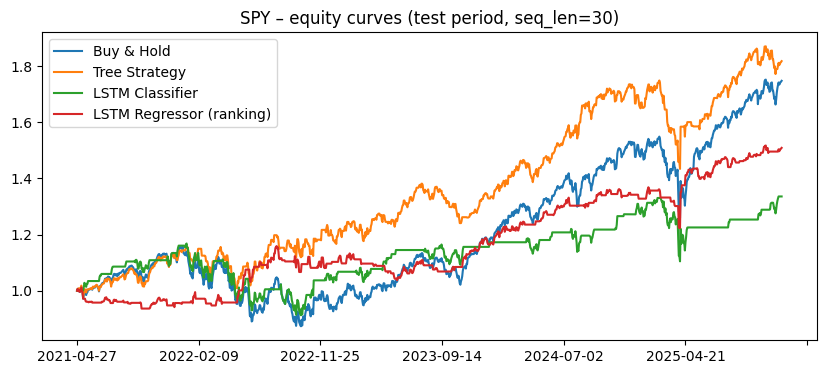

In [31]:
plt.figure(figsize=(10, 4))
equity_bh.plot(label="Buy & Hold")
equity_tree.plot(label="Tree Strategy")
equity_lstm_cls.plot(label="LSTM Classifier")
equity_lstm_reg.plot(label="LSTM Regressor (ranking)")
plt.legend()
plt.title(f"{ticker} – equity curves (test period, seq_len={seq_len})")
plt.show()
